In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [23]:
def find_particle(filename, 
                  init_x=600, 
                  init_y=300, 
                  final_y = 500, 
                  final_x = 800, 
                  filters_kernel=5, 
                  lower_thresh=np.array([10, 10, 10]),
                  upper_thresh=np.array([230, 212, 235]),
                  radius_int=[10, 15],
                  x_int=[20,120],
                  y_int=[20,120]):
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    def __increase_contrast__(image):
        '''Increase contrast in image making the particle easier to be detected

        :param img: Original image
        :type path: np.ndarray
        :return enhanced_img: Image with increased contrast
        :rtype enhanced_img: np.ndarray
        '''
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l_channel, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=0.0005, tileGridSize=(8,8))
        cl = clahe.apply(l_channel)
        limg = cv2.merge((cl,a,b))
        enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        return enhanced_img

    contrast = __increase_contrast__(img)
    contrast = __increase_contrast__(contrast)
    cropped = contrast[init_y:final_y, init_x:final_x]
    for i in range(1):
        cropped = cv2.medianBlur(cropped, filters_kernel)
        cropped = cv2.GaussianBlur(cropped, (filters_kernel, filters_kernel), cv2.BORDER_DEFAULT)
    cropped_hsv = cv2.cvtColor(cropped, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(cropped_hsv, lower_thresh, upper_thresh)
    res = cv2.bitwise_and(cropped, cropped, mask=mask)
    for i in range(5):
        res = cv2.medianBlur(res, filters_kernel)
    contours, _ = cv2.findContours(cv2.Canny(res, 100, 200),  cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        (x,y), radius = cv2.minEnclosingCircle(contour)
        if radius_int[0]<radius<radius_int[1] and x_int[0]<x<x_int[1] and y_int[0]<y<y_int[1]:
            break
    start = (init_x+int(x)-int(radius), init_y+int(y)-int(radius))
    end = (init_x+int(x)+int(radius), init_y+int(y)+int(radius))
    
    sphere = cropped[int(y)-int(radius)+1:int(y)+int(radius),int(x)-int(radius)+1:int(x)+int(radius)]
    def pixel_brightness(pixel):
        assert 3 == len(pixel)
        r, g, b = pixel
        return np.sqrt(0.299 * r ** 2 + 0.587 * g ** 2 + 0.114 * b ** 2)

    brigthness = np.zeros(sphere.shape[:2])
    for i, row in enumerate(sphere):
        for j, pixel in enumerate(row):
            brigthness[i,j] = pixel_brightness(pixel)
                                            
    return contrast, x+init_x, y+init_y, radius, brigthness.mean()

In [24]:
filenames, xs, ys, radiuss, bright_list = [], [], [], [], []
scale = 3
folder = '../data/images'
for image in tqdm(os.listdir(folder)):
    if image.split('.')[1]=='jpg':
        contrast, x, y, radius, bright = find_particle(f'{folder}/{image}')
        filenames.append(image)
        xs.append(x)
        ys.append(y)
        radiuss.append(radius)
        bright_list.append(bright)

 51%|████████████████████▌                   | 331/645 [00:12<00:11, 28.45it/s]/tmp/ipykernel_65108/1755573406.py:59: RuntimeWarning: Mean of empty slice.
  return contrast, x+init_x, y+init_y, radius, brigthness.mean()
/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 645/645 [00:23<00:00, 27.85it/s]


In [26]:
df = pd.DataFrame()
df['filename'] = filenames
df['radius'] = radiuss
df['x'] = xs
df['y'] = ys
df['z'] = bright_list
df['index'] = [int(filename.split('.')[0][5:]) for filename in df['filename'].values]
df.to_csv('../data/dataframes/cbpf.csv', index=None)
df.head()

,filename,radius,x,y,z,index
0,frame583.jpg,13.851260,675.127548,385.581635,93.663941,583
1,frame597.jpg,14.422305,675.000000,385.000000,91.452993,597
2,frame540.jpg,14.214621,674.854836,387.822578,95.846009,540
3,frame226.jpg,13.764314,675.147537,386.926231,94.833818,226
4,frame232.jpg,13.038505,676.000000,387.000000,95.888314,232


In [27]:
len(df)

645

In [31]:
outliers = df[(df['x'] < 660)|(df['x'] > 700)|(df['y'] < 350)|(df['y']>400)]
outliers.to_csv('../data/dataframes/outliers.csv', index=None)
len(outliers)

87

In [32]:
outliers.sort_values(by=['index']).tail()

,filename,radius,x,y,z,index
234,frame640.jpg,3.041481,656.000000,308.500000,64.555767,640
214,frame641.jpg,17.356653,642.000000,377.500000,89.561188,641
251,frame642.jpg,10.062406,647.500000,374.000000,87.285832,642
275,frame643.jpg,2.549610,614.500000,315.500000,66.016737,643
333,frame644.jpg,11.934505,637.768776,380.855728,91.378430,644


In [37]:
df = df[(df['x'] > 660)&(df['x'] < 700)&(df['y'] > 350)&(df['y']<400)]
len(df)
df.to_csv('../data/dataframes/filtered.csv', index=None)

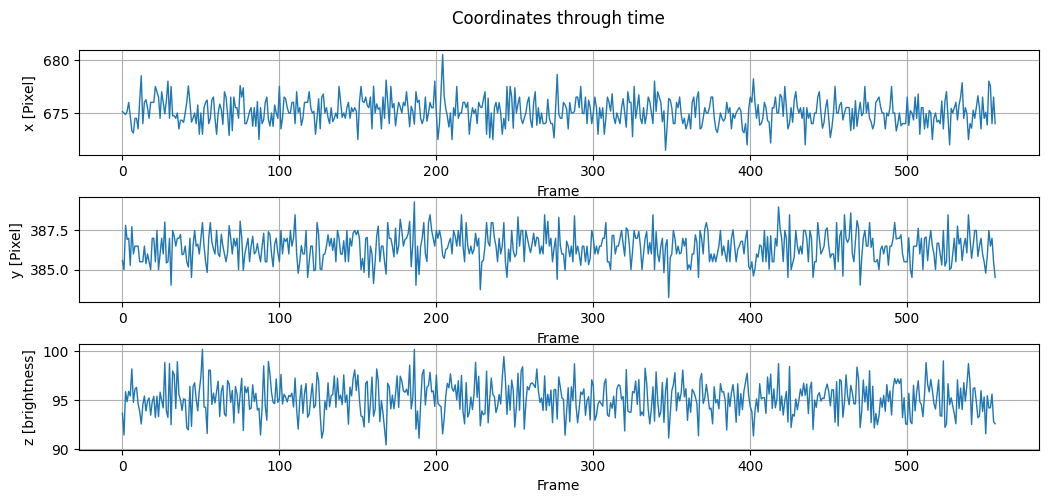

In [39]:
fig, axs = plt.subplots(3)
fig.set_figwidth(12)
fig.set_figheight(5)
fig.suptitle('Coordinates through time')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
axs[0].grid()
axs[0].set_xlabel('Frame')
axs[0].set_ylabel('x [Pixel]')
axs[0].plot(df['x'].values, linewidth=1)
  
axs[1].grid()
axs[1].set_xlabel('Frame')
axs[1].set_ylabel('y [Pixel]')
axs[1].plot(df['y'].values, linewidth=1)

axs[2].grid()
axs[2].set_xlabel('Frame')
axs[2].set_ylabel('z [brightness]')
axs[2].plot(df['z'].values, linewidth=1)

plt.show()